In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from string import punctuation
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('train.csv')#открываем файл csv
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,168449,Monistat 7,Vaginal Yeast Infection,"""So the first time I used this product I was b...",5,11-Aug-16,6
1,1352,Sumatriptan,Migraine,"""I recently was diagnosed with Complex Migrain...",7,31-Aug-12,1
2,27516,DDAVP,Diabetes Insipidus,"""I&#039;ve been on this since 1989. The generi...",10,5-Jun-15,8
3,199352,Depo-Provera,Abnormal Uterine Bleeding,"""I&#039;ve been having constant bleeding or ju...",1,2-May-15,11
4,141790,Escitalopram,Depression,"""Lexapro did help my depression and anxiety, b...",5,25-Apr-11,6


In [ ]:
df['rating'].value_counts()

rating
10    34181
9     18301
1     14439
8     12417
7      6220
5      5346
2      4755
3      4392
6      4169
4      3311
Name: count, dtype: int64

In [ ]:
df.describe() #описательные статистики(usefulcount имеет аномальное максимальное значение)

,uniqueID,rating,usefulCount
count,107531.000000,107531.000000,107531.000000
mean,116029.417275,6.988757,27.937488
std,67016.949799,3.280976,36.378384
min,0.000000,1.000000,0.000000
25%,58134.000000,4.000000,6.000000
50%,115772.000000,8.000000,16.000000
75%,173879.500000,10.000000,36.000000
max,232290.000000,10.000000,1291.000000


возвращает описательный статистический отчет, который включает в себя минимум, первый квартиль, медиану, средний значение, третий квартиль, максимум и дисперсию для числовых столбцов в вашем DataFrame.

In [ ]:
df.info() #информация по колонкам (поле condition имееет пустые поля)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107531 entries, 0 to 107530
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     107531 non-null  int64 
 1   drugName     107531 non-null  object
 2   condition    106934 non-null  object
 3   review       107531 non-null  object
 4   rating       107531 non-null  int64 
 5   date         107531 non-null  object
 6   usefulCount  107531 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.7+ MB


df.info() в Pandas используется для получения обзора структуры данных в DataFrame. Он показывает количество наблюдений (row count), количество столбцов, типы данных для каждого столбца и некоторые другие характеристики, такие как память, используемая каждым столбцом, и наличие отсутствующих значений.

In [ ]:
df = df.dropna(how = 'any', axis = 0) #удаляем пропущенные значения
df.shape

(106934, 7)

In [ ]:
df.info()#теперь колока condition заполнилась нулями

<class 'pandas.core.frame.DataFrame'>
Index: 106934 entries, 0 to 107530
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     106934 non-null  int64 
 1   drugName     106934 non-null  object
 2   condition    106934 non-null  object
 3   review       106934 non-null  object
 4   rating       106934 non-null  int64 
 5   date         106934 non-null  object
 6   usefulCount  106934 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 6.5+ MB


In [ ]:
df.isnull().any()# здесь это подтверждается

uniqueID       False
drugName       False
condition      False
review         False
rating         False
date           False
usefulCount    False
dtype: bool

Text(0.5, 1.0, 'Топ 20 симптомов.')

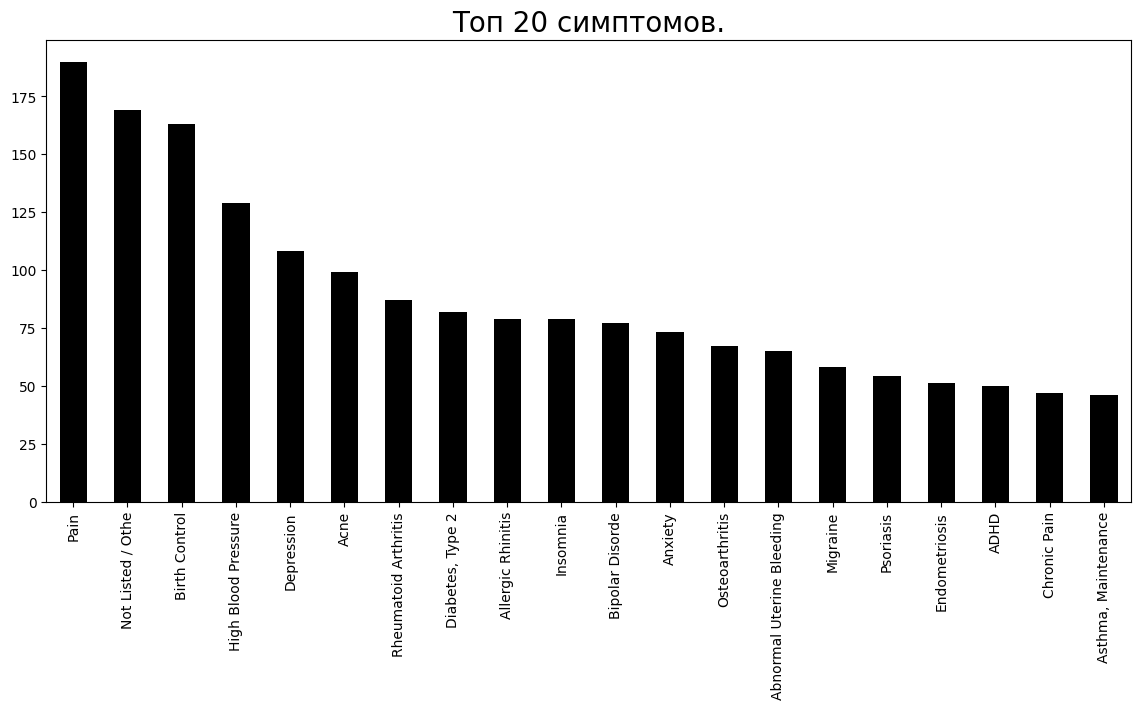

In [ ]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)#диаграмма показывающая топ 20 популярных симптомов
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="black")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Топ 20 симптомов.", fontsize = 20)

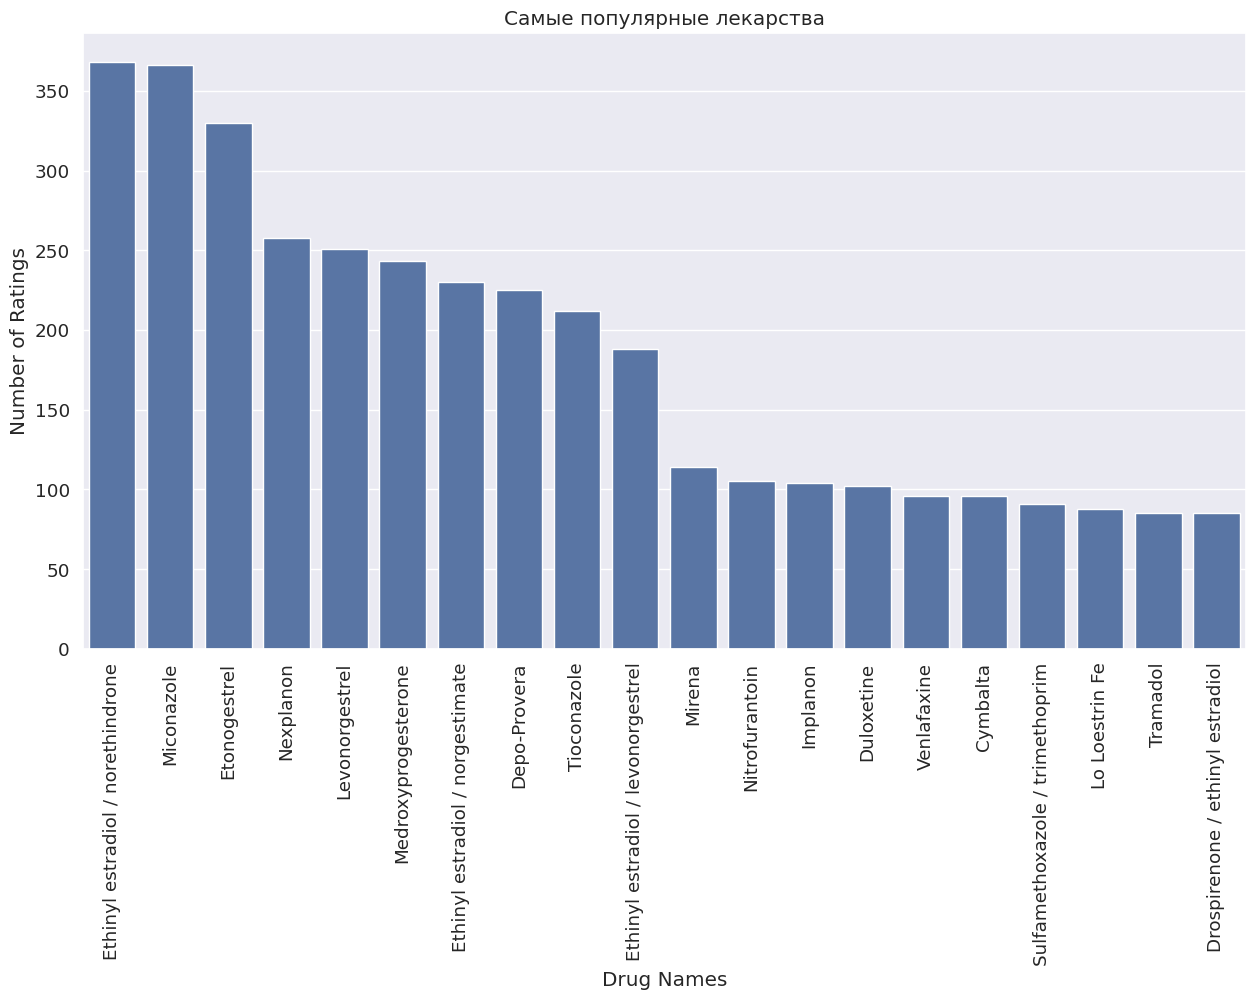

In [ ]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Самые популярные лекарства')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

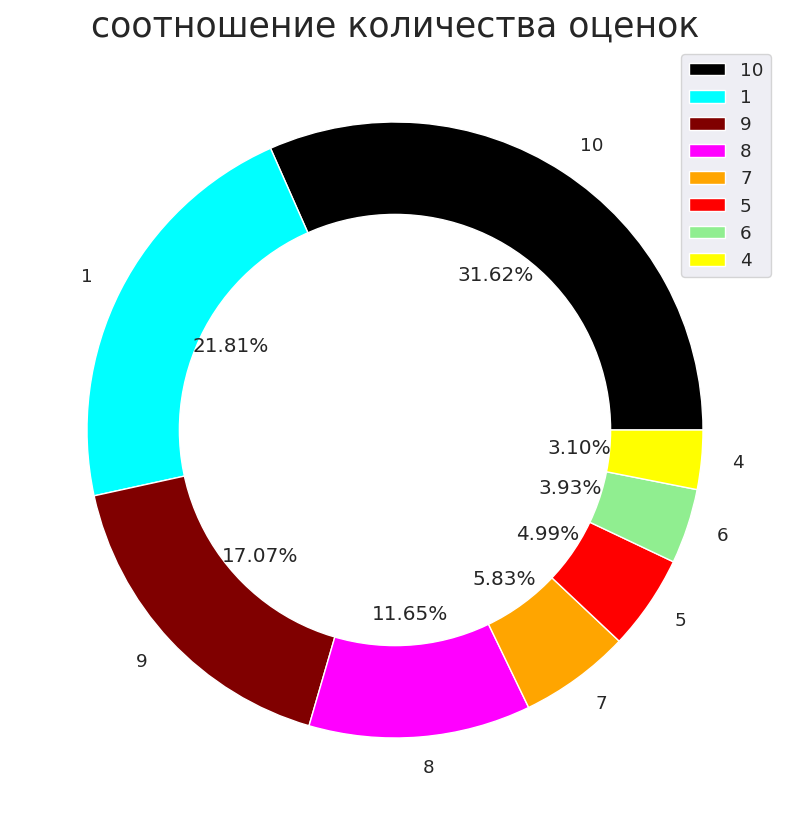

In [ ]:
size = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671]
colors = ['black', 'cyan', 'maroon',  'magenta', 'orange', 'red', 'lightgreen', 'yellow']
labels = "10", "1", "9", "8", "7", "5", "6", "4"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('соотношение количества оценок', fontsize = 25)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

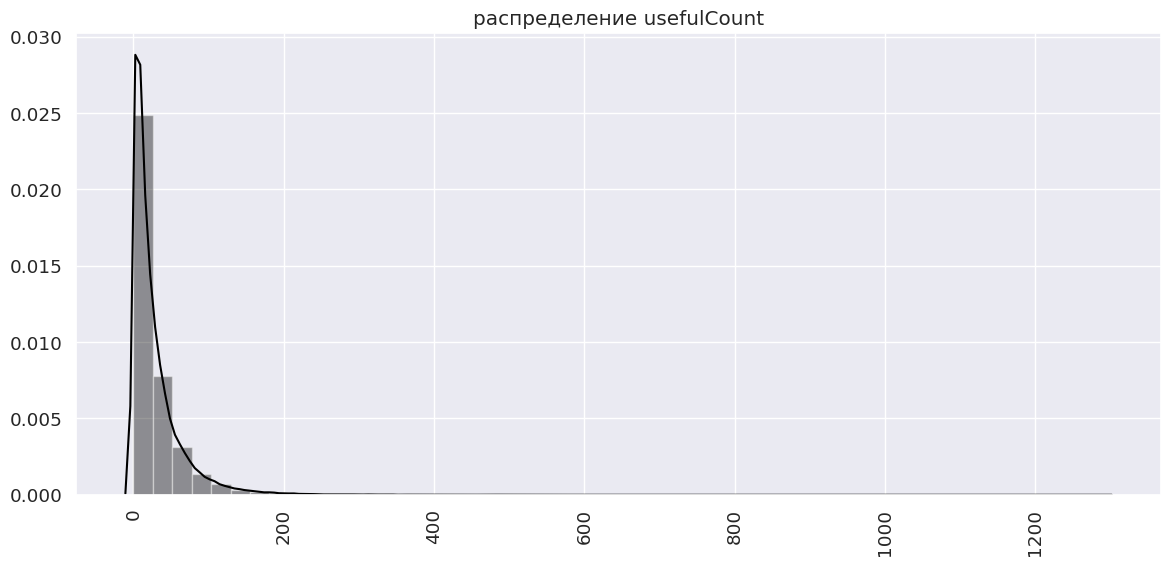

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(df["usefulCount"].dropna(),color="black")# здесь мы видим большой хвост, как мы видели раньше у usefulcount было аномальное максимальное значение
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("распределение usefulCount")
plt.show()

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df.sort_values(['uniqueid'], ascending = True, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,uniqueid,drugname,condition,review,rating,date,usefulcount
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4
1,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7
2,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4
3,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5
4,16,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 and I went on depo for very heavy...",5,15-Oct-15,8


In [ ]:
def review_clean(review):
    # преобразование к нижнему регистру
    lower = review.str.lower()
     # Замена повторяющегося паттерна &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    # удаление повторяющихся символов
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    # удаление символов отличных от ASCII
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    # Удаление начальных и конечных пробелов
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    # замена двойных пробелов одним
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')

    # замена двух или более точек одной
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')

    return dataframe

Этот код очищает текст отзывов, выполняя ряд операций по обработке текста. Вот подробное объяснение каждой строки кода:

lower = review.str.lower(): Преобразует все символы в нижний регистр. Это делается потому, что регистр символа обычно не имеет значения при анализе текста, и это упрощает сравнения.
pattern_remove = lower.str.replace("&#039;", ""): Удаляет символ &#039;, который является HTML-кодом для одинарной кавычки.
`special_remove = pattern_remove.str.replace(r'

In [ ]:
df.review[1001]

'"I have been diagnosed with PCOS for years and have never been given anything for it. I became pregnant in 2003 and now have a beautiful 11 year old. In May 2015 I was diagnosed with type 2 diabetes and have been prescribed Metformin. I take 500mg in the morning and 500mg at night. At first I felt pretty yucky from the medicine. Now that my body has gotten used to it I feel fantastic! I just had my first period in months and am finally beginning to feel like myself. I wasn&#039;t aware the Metformin works well with PCOS until I did some research on the medication. I&#039;m killing two birds with one stone! Wish it helped with my Hypothyroidism."'

In [ ]:
df['review_clean'] = review_clean(df['review'])

In [ ]:
df['review_clean'][1001]

'"i have been diagnosed with pcos for years and have never been given anything for it. i became pregnant in 2003 and now have a beautiful 11 year old. in may 2015 i was diagnosed with type 2 diabetes and have been prescribed metformin. i take 500mg in the morning and 500mg at night. at first i felt pretty yucky from the medicine. now that my body has gotten used to it i feel fantastic! i just had my first period in months and am finally beginning to feel like myself. i wasnt aware the metformin works well with pcos until i did some research on the medication. im killing two birds with one stone! wish it helped with my hypothyroidism."'

In [ ]:
df.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount,review_clean
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,28-Oct-15,4,"""been on the depo injection since january 2015..."
1,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,27-Oct-15,7,"""i have been on the shot 11 years and until a ..."
2,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,25-Oct-15,4,"""i had a total of 3 shots. i got my first one ..."
3,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,21-Oct-15,5,"""im a 30 year old woman. i got the shot on aug..."
4,16,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 and I went on depo for very heavy...",5,15-Oct-15,8,"""im 17 and i went on depo for very heavy bleed..."
5,19,Medroxyprogesterone,Birth Control,"""I took this shot to be safe, I&#039;m a young...",7,14-Oct-15,5,"""i took this shot to be safe, im a young teena..."
6,22,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I got the shot during my 6 week post partum. ...",1,10-Oct-15,5,"""i got the shot during my 6 week post partum. ..."
7,23,Medroxyprogesterone,Birth Control,"""So I have been on the Depo Shot since Februar...",8,10-Oct-15,5,"""so i have been on the depo shot since februar..."
8,27,Medroxyprogesterone,Birth Control,"""I had my first shot when I was 18, I had heav...",1,23-Nov-15,0,"""i had my first shot when i was 18, i had heav..."
9,29,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I got the depo shot in the later part of Sept...",4,22-Nov-15,26,"""i got the depo shot in the later part of sept..."


In [ ]:
df['review_clean'] = review_clean(df['review'])



#удаляем пунктуационные символы
df['review_clean'] = df['review_clean'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

# данная строка кода удаляет стоп-слова (слова, которые обычно не несут смысловой нагрузки, такие как артикли, предлоги и т.д.)
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [ ]:
#новые столбцы 'day', 'month' и 'year', содержащие соответствующие значения из столбца 'date'
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

Этот код создает новые столбцы в DataFrame, называемые 'day', 'month' и 'year'. Эти столбцы будут содержать информацию о дне, месяце и годе соответственно, извлеченную из столбца 'date'. Сначала код преобразует значения в столбце 'date' в формат datetime с помощью функции pd.to_datetime(). Затем он использует методы доступа к элементам времени (dt) для создания новых столбцов
Это может быть полезно, если вам нужно анализировать данные по дням, месяцам или годам отдельно, без необходимости каждый раз разбирать дату.

In [ ]:
def sentiment(review):
    # контраст настроений в отзывах варируется от (-1 до 1) где -1-отрицательный , 0-нейтральный, 1-положительный
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

Этот код определяет функцию, которая анализирует отзывы и возвращает уровень положительного или отрицательного настроения в каждом из них. Функция `TextBlob` из библиотеки TextBlob используется для анализа текста и определения его настроения. Она возвращает число, которое представляет собой степень положительности или отрицательности отзыва, где большие значения соответствуют более сильным положительным или отрицательным настроениям. В этом коде эти значения затем добавляются в список `pol`.

In [ ]:
df['sentiment'] = sentiment(df['review'])
df['sentiment_clean'] = sentiment(df['review_clean'])

Этот код добавляет новый столбец 'sentiment' в DataFrame `df`, содержащий результаты анализа настроений для каждого отзыва в столбце 'review'. Аналогично, он добавляет столбец 'sentiment_clean', содержащий результаты анализа настроений для очищенных отзывов в столбце 'review_clean'. Функция `sentiment` вызывается для каждого ряда в этих столбцах и возвращает список значений настроений, которые затем добавляются в соответствующие столбцы DataFrame.

In [ ]:
df['review_clean_ss'] = review_clean(df['review'])

df['review_clean_ss'] = df['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

df['sentiment_clean_ss'] = sentiment(df['review_clean_ss'])

Этот код выполняет дополнительную очистку текста отзывов и анализ их настроений. Вот что он делает:

1. `df['review_clean_ss'] = review_clean(df['review'])`: Здесь вызывается функция `review_clean`, которая выполняет очистку текста отзывов. Результаты этой очистки сохраняются в новом столбце `review_clean_ss`.

2. `df['review_clean_ss'] = df['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))` : Здесь происходит еще одна очистка текста, в ходе которой из текста удаляются все символы пунктуации. Переменная `punctuation`, вероятно, содержит список всех символов пунктуации, которые нужно удалить.

3. `df['sentiment_clean_ss'] = sentiment(df['review_clean_ss'])`: После окончательной очистки текста, вызывается функция `sentiment`, чтобы проанализировать настроение каждого отзыва и сохранить результаты в новом столбце `sentiment_clean_ss`.

In [ ]:
df['count_word']=df["review_clean_ss"].apply(lambda x: len(str(x).split()))
df['count_unique_word']=df["review_clean_ss"].apply(lambda x: len(set(str(x).split())))
df['count_letters']=df["review_clean_ss"].apply(lambda x: len(str(x)))
df["count_punctuations"] = df["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df["count_words_upper"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df["count_words_title"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df["count_stopwords"] = df["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

Этот код создает несколько новых столбцов в DataFrame, которые содержат различные метрики, связанные с текстом отзывов. Вот что делают эти строки кода:

1. `df['count_word']=df["review_clean_ss"].apply(lambda x: len(str(x).split()))`: Создает столбец `count_word`, который содержит количество слов в каждом отзыве.

2. `df['count_unique_word']=df["review_clean_ss"].apply(lambda x: len(set(str(x).split())))`: Создает столбец `count_unique_word`, который содержит количество уникальных слов в каждом отзыве.

3. `df['count_letters']=df["review_clean_ss"].apply(lambda x: len(str(x)))`: Создает столбец `count_letters`, который содержит общее количество символов в каждом отзыве.

4. `df["count_punctuations"] = df["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))`: Создает столбец `count_punctuations`, который содержит количество пунктуационных символов в каждом отзыве.

5. `df["count_words_upper"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))`: Создает столбец `count_words_upper`, который содержит количество слов, написанных заглавными буквами, в каждом отзыве.

6. `df["count_words_title"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))`: Создает столбец `count_words_title`, который содержит количество слов, написанных в стиле заголовка, в каждом отзыве.

7. `df["count_stopwords"] = df["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))`: Создает столбец `count_stopwords`, который содержит количество стоп-слов в каждом отзыве. Стоп-слова - это часто встречающиеся слова, которые не несут большого смысла для анализа настроений, такие как "и", "в", "на" и т.д.

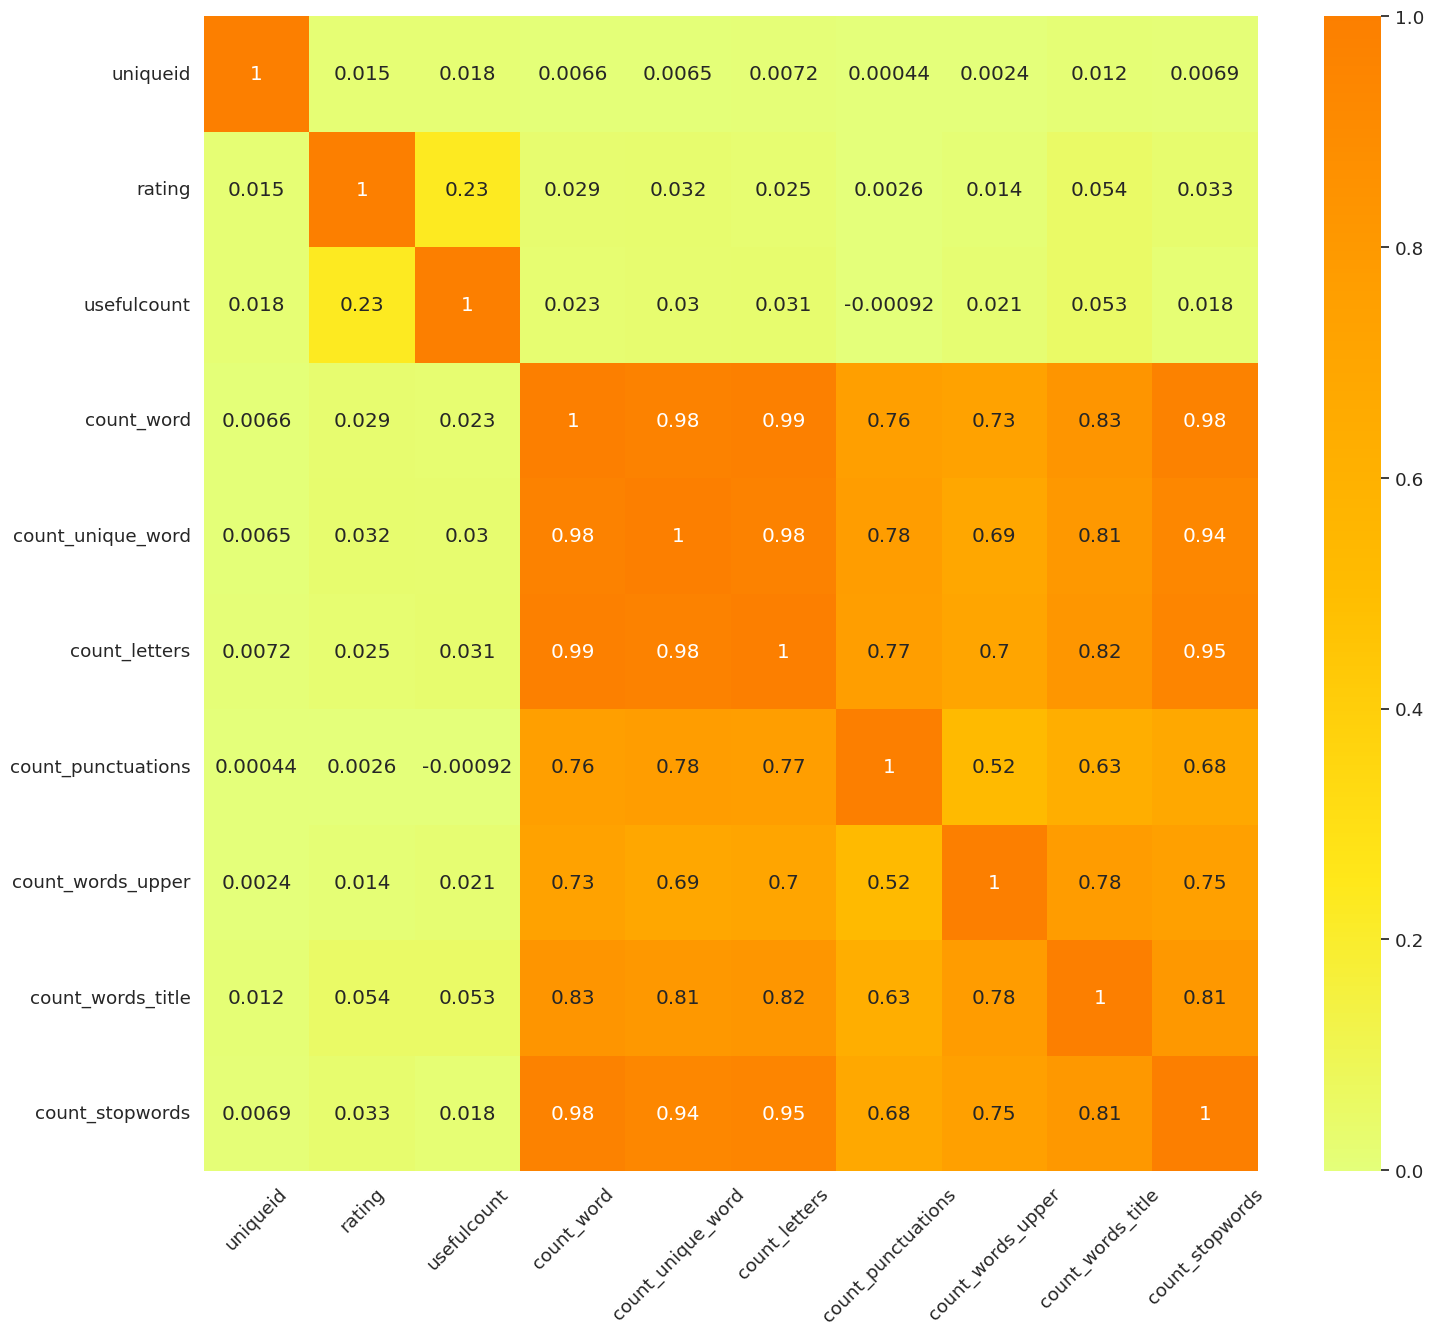

In [ ]:
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = df.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'Wistia')
plt.setp(sns_.get_xticklabels(), rotation = 45);

по матрице кореляции можно сделать вывод что больше всего влият на рейтинг параметры count_words_title, usefulcount

In [ ]:
df.head(10)

,uniqueid,drugname,condition,review,rating,date,usefulcount,review_clean,day,month,...,sentiment_clean,review_clean_ss,sentiment_clean_ss,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords
0,0,Medroxyprogesterone,Abnormal Uterine Bleeding,"""Been on the depo injection since January 2015...",3,2015-10-28,4,depo injection since january 2015 bleeding sto...,28,10,...,-0.192857,been on the depo injection since january 2015 ...,-0.192857,99,74,542,31,6,14,45
1,3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8,2015-10-27,7,shot 11 years month ago never 1 period even sp...,27,10,...,-0.075000,i have been on the shot 11 years and until a m...,-0.210000,59,45,282,12,4,5,28
2,5,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1,2015-10-25,4,total 3 shots got first one leaving hospital g...,25,10,...,0.053030,i had a total of 3 shots i got my first one be...,0.044872,152,102,728,21,13,20,79
3,9,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m a 30 year old woman. I got the shot ...",2,2015-10-21,5,im 30 year old woman got shot august 9th bleed...,21,10,...,0.291667,im a 30 year old woman i got the shot on augus...,0.265309,65,52,309,25,4,7,29
4,16,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 17 and I went on depo for very heavy...",5,2015-10-15,8,im 17 went depo heavy bleeding like heavy woul...,15,10,...,0.020203,im 17 and i went on depo for very heavy bleedi...,-0.057738,158,101,742,16,9,10,84
5,19,Medroxyprogesterone,Birth Control,"""I took this shot to be safe, I&#039;m a young...",7,2015-10-14,5,took shot safe im young teenager sexually acti...,14,10,...,0.189744,i took this shot to be safe im a young teenage...,0.203590,133,79,616,25,12,14,72
6,22,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I got the shot during my 6 week post partum. ...",1,2015-10-10,5,got shot 6 week post partum nurse seen highly ...,10,10,...,0.082778,i got the shot during my 6 week post partum th...,0.061026,127,91,621,30,7,7,50
7,23,Medroxyprogesterone,Birth Control,"""So I have been on the Depo Shot since Februar...",8,2015-10-10,5,depo shot since february problems overall love...,10,10,...,0.233333,so i have been on the depo shot since february...,0.190000,112,69,557,26,9,24,59
8,27,Medroxyprogesterone,Birth Control,"""I had my first shot when I was 18, I had heav...",1,2015-11-23,0,first shot 18 heavy bleeding weight gain whole...,23,11,...,0.097436,i had my first shot when i was 18 i had heavy ...,0.090476,128,77,606,20,11,18,67
9,29,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I got the depo shot in the later part of Sept...",4,2015-11-22,26,got depo shot later part september october did...,22,11,...,0.000000,i got the depo shot in the later part of septe...,0.000000,70,51,352,24,7,12,31


In [ ]:
df['review_clean_ss'][1001]

'i have been diagnosed with pcos for years and have never been given anything for it i became pregnant in 2003 and now have a beautiful 11 year old in may 2015 i was diagnosed with type 2 diabetes and have been prescribed metformin i take 500mg in the morning and 500mg at night at first i felt pretty yucky from the medicine now that my body has gotten used to it i feel fantastic i just had my first period in months and am finally beginning to feel like myself i wasnt aware the metformin works well with pcos until i did some research on the medication im killing two birds with one stone wish it helped with my hypothyroidism'

In [ ]:
df.review[1001]

'"I have been diagnosed with PCOS for years and have never been given anything for it. I became pregnant in 2003 and now have a beautiful 11 year old. In May 2015 I was diagnosed with type 2 diabetes and have been prescribed Metformin. I take 500mg in the morning and 500mg at night. At first I felt pretty yucky from the medicine. Now that my body has gotten used to it I feel fantastic! I just had my first period in months and am finally beginning to feel like myself. I wasn&#039;t aware the Metformin works well with PCOS until I did some research on the medication. I&#039;m killing two birds with one stone! Wish it helped with my Hypothyroidism."'

In [ ]:
label_encoder_feat = {}
for feature in ['drugname', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df[feature] = label_encoder_feat[feature].fit_transform(df[feature])

Этот код создает словарь `label_encoder_feat`, который будет использоваться для кодирования двух столбцов в DataFrame `df` с именами 'drugname' и 'condition'. Для каждого из этих столбцов создается экземпляр класса `LabelEncoder` из библиотеки sklearn. Этот класс используется для преобразования категориальных переменных в числовые. Метод `fit_transform()` сначала обучается на данных, а затем преобразует их. В результате в DataFrame `df` вместо исходных значений в столбцах 'drugname' и 'condition' появятся числовые коды.

In [ ]:
X = df[['condition', 'usefulcount', 'sentiment', 'day', 'month', 'year',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords',]]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
print (X_train.shape)
print (X_test.shape)

(96240, 14)
(10694, 14)


Этот код выполняет следующие действия:

1. Создает объекты `X` и `y`, которые представляют собой данные для обучения и целевую переменную соответственно. `X` содержит выбранные столбцы из исходного DataFrame, а `y` содержит значения рейтинга.

2. Использует функцию `train_test_split` из библиотеки sklearn для разделения данных на обучающую и тестовую выборки. Размер тестовой выборки составляет 10% от общего объема данных (test_size = 0.1), а случайный штамп (random_state = 42) гарантирует, что результаты будут воспроизводимыми.

3. Выводит размеры полученных выборок. Например, если исходный DataFrame имел размер 1000 строк, то после разделения мы получим:
   - X_train: 900 строк (90% от исходного размера)
   - X_test: 100 строк (10% от исходного размера)

Таким образом, этот код подготавливает данные для дальнейшего обучения модели машинного обучения.

In [ ]:
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.03,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train, y_train)

predictions = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y_test, predictions), '\n')

print (classification_report(y_test, predictions))

The Accuracy of the model is :  0.5725640546100618 

The confusion Matrix is 

[[1020   20   14    5   18    3   12   37   77  299]
 [ 103  193    3    3    7    1    4   20   40  102]
 [  82    5  163    0   10    3    4   20   31  101]
 [  72    6    2  134    9    5    5   12   17   90]
 [  88    2    4    5  196    3    7   25   51  154]
 [  47    4    3    1    6  141   16   22   45  111]
 [  42    2    5    3    5    4  237   45   66  218]
 [  87    6    4    4    9    6    8  491  137  461]
 [  95    8    6    2   10    3   23  111  828  765]
 [ 169   11   11    2   13    6   15   99  274 2720]] 

              precision    recall  f1-score   support

           1       0.57      0.68      0.62      1505
           2       0.75      0.41      0.53       476
           3       0.76      0.39      0.51       419
           4       0.84      0.38      0.52       352
           5       0.69      0.37      0.48       535
           6       0.81      0.36      0.49       396
         

In [ ]:
df = pd.read_csv('test.csv')#открываем файл csv
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,150990,Sulfamethoxazole / trimethoprim,Sinusitis,"""Horrible headache and stomach ache. Had to di...",3,3-Feb-09,29
1,72004,Tramadol,Restless Legs Syndrome,"""If I could give it a negative 10, I would. I...",1,25-Sep-15,12
2,30649,Miconazole,Vaginal Yeast Infection,"""I took a generic brand 1 day miconazole. HUGE...",1,7-Oct-17,7
3,223139,Estradiol,Postmenopausal Symptoms,"""Cannot get it to stay on. Don&#039;t know why...",2,26-Jul-15,25
4,62654,Nicoderm CQ,Smoking Cessation,"""My only regret is not trying this sooner! Cou...",10,15-Feb-17,18


In [ ]:
df = df.dropna(how = 'any', axis = 0) #удаляем пропущенные значения
df.shape

(63662, 7)

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
df['review_clean'] = review_clean(df['review'])

In [ ]:
df['review_clean'] = review_clean(df['review'])

#удаляем пунктуационные символы
df['review_clean'] = df['review_clean'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

# данная строка кода удаляет стоп-слова (слова, которые обычно не несут смысловой нагрузки, такие как артикли, предлоги и т.д.)
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [ ]:
#новые столбцы 'day', 'month' и 'year', содержащие соответствующие значения из столбца 'date'
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [ ]:
def sentiment(review):
    # контраст настроений в отзывах варируется от (-1 до 1) где -1-отрицательный , 0-нейтральный, 1-положительный
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [ ]:
df['sentiment'] = sentiment(df['review'])
df['sentiment_clean'] = sentiment(df['review_clean'])

In [ ]:
df['review_clean_ss'] = review_clean(df['review'])

df['review_clean_ss'] = df['review_clean_ss'].apply(lambda x: ''.join(word for word in x if word not in punctuation))

df['sentiment_clean_ss'] = sentiment(df['review_clean_ss'])

In [ ]:
df['count_word']=df["review_clean_ss"].apply(lambda x: len(str(x).split()))

#создаем новый столбец count_word , который содержит количество слов в каждом отзыве
df['count_unique_word']=df["review_clean_ss"].apply(lambda x: len(set(str(x).split())))

#создаем столбец count_unique_word, который содержит количество уникальных слов в каждом отзыве
df['count_letters']=df["review_clean_ss"].apply(lambda x: len(str(x)))

#мы создаем столбец count_letters, который содержит количество символов в каждом отзыве
df["count_punctuations"] = df["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#создаем столбец count_punctuations, который содержит количество пунктуационных символов в каждом отзыве
df["count_words_upper"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#создаем столбец count_words_upper, который содержит количество слов, написанных заглавными буквами, в каждом отзыве
df["count_words_title"] = df["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#создаем столбец count_stopwords, который содержит количество стоп-слов в каждом отзыве
df["count_stopwords"] = df["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

In [ ]:
label_encoder_feat = {}
for feature in ['drugname', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    df[feature] = label_encoder_feat[feature].fit_transform(df[feature])

In [ ]:
X = df[['condition', 'usefulcount', 'sentiment', 'day', 'month', 'year',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_words_upper', 'count_words_title',
                   'count_stopwords',]]
y = df['rating']

In [ ]:
y_pred=model.predict(X)

In [ ]:
print ("The Accuracy of the model is : ", accuracy_score(y, y_pred), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y, y_pred), '\n')

print (classification_report(y, y_pred))